In [1]:
import time
import json
import talib 
import requests
import numpy as np 
import pandas as pd
import psycopg2 as pg 
import mplfinance as mpf
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec#分割子图 
from dateutil.parser import parse

In [2]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [3]:
np.seterr(divide='ignore',invalid='ignore') # 忽略warning
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号 
fig = plt.figure(figsize=(20,12), dpi=100,facecolor="white") #创建fig对象

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

<Figure size 2000x1200 with 0 Axes>

In [4]:
instruments = ['600513.SS']
header = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"}

In [5]:
ended = "2023-11-09 20:30:00"
timeArray = time.strptime(ended, "%Y-%m-%d %H:%M:%S")
timestamp = int(time.mktime(timeArray))
formatted_date = time.strftime("%Y%m%d", timeArray)

print(timestamp)
print(formatted_date)

1699533000
20231109


In [6]:
for instrument in instruments:
    SE = instrument.split(".")[1]
    if SE == "SS":
        instrument = instrument.split(".")[0]
        jquery = f'jQuery11240884023465957779_{timestamp}'
        # api = f"https://yunhq.sse.com.cn:32042/v1/sh1/line/{instrument}?callback={jquery}&select=time%2Cprice%2Cvolume%2Cavg_price%2Camount%2Chighest%2Clowest&_={timestamp}"
        api = f'https://yunhq.sse.com.cn:32042/v1/sh1/mink/{instrument}?callback={jquery}&select=date%2Cclose%2CprevClose%2Cvolume%2Chigh%2Clow%2Cavg&begin=0&end=-1&period={formatted_date}&_={timestamp}'
        res = requests.get(api, headers=header)
        result = json.loads(res.text[len(jquery)+1:-1])
        items = result['kline']
        dataresult = pd.DataFrame()
        for data in items:
            columns = {
            "Date": [ parse(str(data[0])).strftime("%Y-%m-%d %H:%M:%S") ],
            "Open": data[2],
            "High": data[4],
            "Low": data[5],
            "Close": data[1],
            "Average": data[6],
            "Volume": data[3],
            }
            dataresult = pd.concat([dataresult, pd.DataFrame(columns)], axis=0)
            # dataresult = dataresult.append(pd.DataFrame(columns), ignore_index=True)

    if SE == "SZ":
        # https://www.szse.cn/market/trend/index.html?code=399300
        instrument = instrument.split(".")[0]
        api = f"https://www.szse.cn/api/market/ssjjhq/getTimeData?random=0.2024269370830547&marketId=1&code={instrument}"
        item = {}
        item['code'] = "%s.SZ"%result['data']['code']
        item['name'] = result['data']["name"]
        item['time'] = result['datetime']
        item['last_close'] = result['data']['close']
        item['today_open'] = result['data']['open']
        item['today_max'] = result['data']['high']
        item['today_min'] = result['data']['low']
        item['today_now'] = result['data']['now']
        item['delta_amount'] = result['data']["delta"]
        item['delta_percentage'] = result['data']["deltaPercent"]
        item['volume_times'] = result['data']['volume']
        item['volume_amount'] = result['data']['amount']
        item['arise_amount'] = float(item['today_open']) - float(item['last_close'])
        item['arise_percentage'] = float(item['arise_amount']) / float(item['last_close'])
    
    print(dataresult)


                   Date   Open   High    Low  Close  Average   Volume
0   2023-11-09 09:30:00  10.64  10.84  10.84  10.84   10.840   293900
0   2023-11-09 09:31:00  10.64  11.07  10.87  10.90   10.930  1422600
0   2023-11-09 09:32:00  10.64  10.93  10.72  10.90   10.893  1527700
0   2023-11-09 09:33:00  10.64  10.93  10.81  10.93   10.891   412280
0   2023-11-09 09:34:00  10.64  10.93  10.86  10.87   10.891   351300
..                  ...    ...    ...    ...    ...      ...      ...
0   2023-11-09 14:56:00  10.64  10.71  10.67  10.67   10.929   149400
0   2023-11-09 14:57:00  10.64  10.68  10.67  10.68   10.928   119800
0   2023-11-09 14:58:00  10.64  10.68  10.68  10.68   10.928     6400
0   2023-11-09 14:59:00  10.64  10.68  10.68  10.68   10.928        0
0   2023-11-09 15:00:00  10.64  10.69  10.68  10.69   10.924   318400

[241 rows x 7 columns]


In [7]:
dataresult['Date'] = pd.to_datetime(dataresult['Date'])
dataresult.set_index('Date', inplace=True)
dataresult

,Open,High,Low,Close,Average,Volume
Date,,,,,,
2023-11-09 09:30:00,10.64,10.84,10.84,10.84,10.840,293900
2023-11-09 09:31:00,10.64,11.07,10.87,10.90,10.930,1422600
2023-11-09 09:32:00,10.64,10.93,10.72,10.90,10.893,1527700
2023-11-09 09:33:00,10.64,10.93,10.81,10.93,10.891,412280
2023-11-09 09:34:00,10.64,10.93,10.86,10.87,10.891,351300
...,...,...,...,...,...,...
2023-11-09 14:56:00,10.64,10.71,10.67,10.67,10.929,149400
2023-11-09 14:57:00,10.64,10.68,10.67,10.68,10.928,119800
2023-11-09 14:58:00,10.64,10.68,10.68,10.68,10.928,6400


In [8]:
%matplotlib widget

(<Figure size 960x690 with 4 Axes>,
 [<Axes: ylabel='Price'>,
  <Axes: >,
  <Axes: ylabel='Volume  $10^{6}$'>,
  <Axes: >])

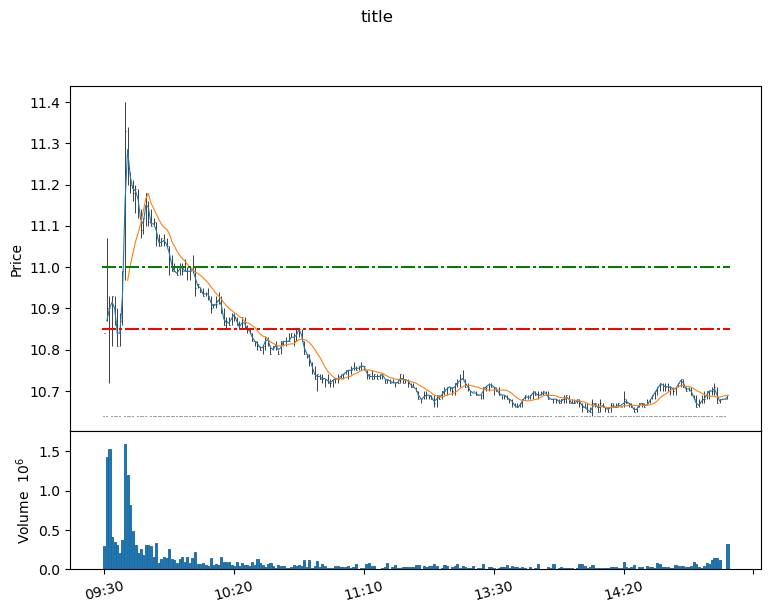

In [8]:
mc = mpf.make_marketcolors(up= 'r',down= 'g') 
s = mpf.make_mpf_style(marketcolors= mc)
hline = dict(hlines=[11,10.85], colors=['g','r'], linestyle='-.')
mpf.plot(dataresult, title= "title", figscale= 1.2, mav=(2, 10), volume= True ,type= 'ohlc',style= s, ylabel= "Price", show_nontrading= False ,block= True ,xrotation= 15,returnfig= True, hlines=hline )

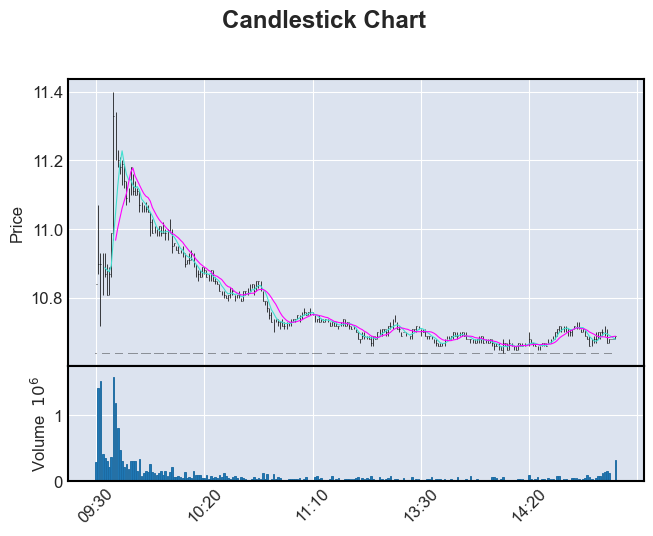

In [9]:
mpf.plot(dataresult, type='ohlc', mav=(5, 10), volume=True, show_nontrading=False, title='Candlestick Chart', ylabel='Price')
